In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from matplotlib import pyplot as plt
from numpy import mean
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, auc, f1_score, precision_score,
                             recall_score, roc_auc_score, silhouette_score)
from sklearn.model_selection import (GridSearchCV, RepeatedStratifiedKFold,
                                     ShuffleSplit, StratifiedShuffleSplit,
                                     cross_val_score)
from sklearn.ensemble import RandomForestClassifier

In [2]:
IMAGES_PATH = "Image"

In [3]:
def concat_two_df_and_drop_same_column_in_df2(DF1, DF2):
    display(DF1.head(1))
    display(DF2.head(1))
    DF2.drop(DF2.columns[DF2.columns.isin(DF1.columns)],axis=1,inplace=True)
#     DF1.drop(DF1.columns[DF1.columns.isin(DF2.columns)],axis=1,inplace=True)
    result = pd.concat([DF1, DF2], axis=1)
    display(result.head(1))
    return result
def count_list_val(arr):
    values, counts = np.unique(arr, return_counts=True)
    print(values, counts)

In [4]:
four_time = pd.read_csv("CSV/four_time.csv")
v_value = pd.read_csv("CSV/v_value.csv")
mic = pd.read_csv("CSV/mic.csv")
dwt_distance = pd.read_csv("CSV/sdtw_day_score_df.csv")
smart_meter = pd.read_csv("smart_meter.csv")

In [5]:
fdi = pd.read_csv("CSV/FDI.csv")
fdi_4225 = pd.read_csv("CSV/FDI_4225.csv")

In [6]:
result = concat_two_df_and_drop_same_column_in_df2(fdi, v_value)
result = concat_two_df_and_drop_same_column_in_df2(result, four_time)
result = concat_two_df_and_drop_same_column_in_df2(result, mic)
result = concat_two_df_and_drop_same_column_in_df2(result, dwt_distance)
result.columns

,MeterID,Day,FDI
0,1236,2009-07-15,1.0


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,5212,2010-12-31,True,12,30,15,0.046464,0.047532,0.013561


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561


,MeterID,Day,FDI,overnight,breakfast,daytime,evening
0,1236,2009-07-15,True,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,mic
0,1236,2009-07-15,True,0.624128


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128


,MeterID,Day,FDI,meter_dtw,meter_sdtw
0,1236,2009-07-15,True,2.283294,-68.276715


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic,meter_dtw,meter_sdtw
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128,2.283294,-68.276715


Index(['MeterID', 'Day', 'FDI', 'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2',
       'Cmin1', 'overnight', 'breakfast', 'daytime', 'evening', 'mic',
       'meter_dtw', 'meter_sdtw'],
      dtype='object')

In [7]:
result = result.drop(['Day', 'MeterID', 'FDI'], axis=1)
t = np.array(result).reshape(4225, -1)
len(t[0])

6890

In [18]:
6890/530

13.0

In [9]:
count_list_val(fdi_4225)

[0 1] [3805  420]


In [10]:
df = pd.DataFrame(t)

In [11]:
partition = 422*6
evaluation = 422*2
total = 4225

In [12]:
def train_model(X, Y, score = False, split_num = 3, return_model=False ):
    

    partition = 422*8*530
    evaluation = 422*1*530
    total = 4225

    round = 1
    average_score = {}
    average_score["precision_score"] = 0
    average_score["recall_score"] = 0
    average_score["accuracy_score"] = 0
    average_score["roc_auc_score"] = 0
    average_score["f1_score"] = 0

    X_train = X[:total]
    y_train = Y[:total]

    sss = StratifiedShuffleSplit(n_splits=split_num, test_size=0.4, random_state=1)
    for train_index, test_index in sss.split(X_train, y_train):
#         test_index = np.concatenate((np.array(test_index), np.array(X[total-(partition+evaluation): total].index)))
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = np.array(Y.iloc[train_index]).reshape(-1) , np.array(Y.iloc[test_index]).reshape(-1)

        model = RandomForestClassifier()
        model.fit(X_train, Y_train)
        y_hat = model.predict(X_test)
        average_score["precision_score"] += precision_score(Y_test, y_hat)
        average_score["recall_score"] += recall_score(Y_test, y_hat)
        average_score["accuracy_score"] += accuracy_score(Y_test, y_hat)
        average_score["roc_auc_score"] += roc_auc_score(Y_test, y_hat)
        average_score["f1_score"] += f1_score(Y_test, y_hat)

        if score:
            print("round: " + str(round))
            print("precision score: " + str(precision_score(Y_test, y_hat)))
            print("recall_score: " + str(recall_score(Y_test, y_hat)))
            print("accuracy_score: " + str(accuracy_score(Y_test, y_hat)))
            print("roc_auc_score: " + str(roc_auc_score(Y_test, y_hat)))
            print("f1_score: " + str(f1_score(Y_test, y_hat)))
            print()

        round += 1
    for key, score in average_score.items():
        average_score[key] = score / split_num
        print("average_" + key + ": " + str(average_score[key]))
    if return_model==True:
        return model, average_score
    return average_score

def get_permutation_importance(model, X_val, y_val, title=None, origin=False, save=False):
    
    if save_fig == True and title == None:
        raise NameError('Please type the title for the chart to save')
        
    r = permutation_importance(model, X_val, y_val, n_repeats=5, random_state=0)
    four_time_importance = sum(r.importances_mean[:3])
    mic_importance = r.importances_mean[10]
    v_value_importance = sum(r.importances_mean[4:10])
    dtw_importance = r.importances_mean[11]
    sdtw_importance = r.importances_mean[12]
    if origin == True:
        print('include origin data')
        origin_importance = sum(r.importances_mean[13:])
        importance = { "four_time": four_time_importance, "mic": mic_importance, "v_value": v_value_importance,
                  "dtw": dtw_importance, "sdtw": sdtw_importance, 'origin':origin_importance}
    else:
        print('no origin data')
        importance = { "four_time": four_time_importance, "mic": mic_importance, "v_value": v_value_importance, "dtw": dtw_importance, "sdtw": sdtw_importance}
    
    importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))
    
    y_label = list(importance.keys())
    y_pos = np.arange(len(importance))

    plt.rcdefaults()
    fig, ax = plt.subplots()

    ax.barh(y_pos, list(importance.values()), align='center')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_label)

    ax.set_xlabel('Importance Mean')
    ax.set_title('Permutation importance')
    
    if save == True:
        save_fig('Permutation importance: '+ title)
        
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, image_path = IMAGES_PATH):
    path = os.path.join(image_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [13]:
# 6:4 and seperate train and test dataset
# 13 features
model, score = train_model(df, fdi_4225 , return_model=True)
# get_permutation_importance(model, result[col][partition:], result['FDI'][partition:], title= TITLE, origin=True, save=True)

average_precision_score: 0.9518200043398982
average_recall_score: 0.9781746031746033
average_accuracy_score: 0.9928994082840236
average_roc_auc_score: 0.9863496756565088
average_f1_score: 0.9647612305422579


include origin data
Saving figure Permutation importance: RandomForest: permutation importance


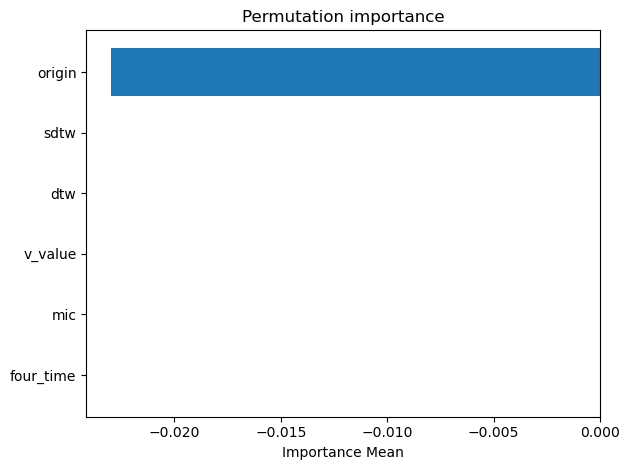

In [14]:
TITLE = "RandomForest: permutation importance"
get_permutation_importance(model, df[partition:], fdi_4225[partition:], title= TITLE, origin=False, save=True)

In [16]:
df

,0,1,2,3,4,5,6,7,8,9,...,6880,6881,6882,6883,6884,6885,6886,6887,6888,6889
0,12.0,30.0,15.0,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,...,0.062558,0.195373,0.004996,0.055890,0.021836,0.079899,0.107285,0.661153,2.085025,-68.084861
1,11.0,34.0,29.0,0.062141,0.049603,0.011582,5.381572,15.5,24.5,38.0,...,0.103607,0.102552,0.026780,0.230186,0.356422,0.273682,0.298346,0.706253,1.155201,-75.011779
2,20.0,36.0,35.0,0.344601,0.015860,0.003204,5.540882,15.5,24.5,38.0,...,0.016341,0.012977,0.001762,0.372834,0.181750,0.428071,1.096077,0.626410,2.711514,-67.688966
3,21.0,31.0,24.0,0.070646,0.066001,0.018685,5.399084,15.5,24.5,38.0,...,0.070026,0.069379,0.020235,0.142738,0.155469,0.161250,0.155071,0.530101,1.931414,-71.362942
4,16.0,40.0,20.0,0.253180,0.598008,0.010881,5.500824,15.5,24.5,38.0,...,0.079963,0.080023,0.021268,0.233892,0.259253,0.183596,0.224460,0.698209,1.548766,-73.599238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4220,13.0,39.0,16.0,0.244305,0.620242,0.034398,5.438176,15.5,24.5,38.0,...,0.081945,0.070020,0.025837,0.559941,0.283000,1.320071,1.078000,0.146094,5.541296,-38.456678
4221,26.0,42.0,29.0,0.077440,0.080601,0.002766,5.369529,15.5,24.5,38.0,...,0.377914,0.365468,0.042473,0.045706,0.078500,0.095000,0.203385,0.146094,1.368876,-73.618095
4222,15.0,46.0,34.0,0.220902,0.498777,0.011709,5.550353,15.5,24.5,38.0,...,0.165851,0.113072,0.000000,0.728118,0.241500,0.276857,2.546154,0.146094,9.486484,25.515755
4223,13.0,47.0,16.0,0.034376,0.106234,0.004273,5.393765,15.5,24.5,38.0,...,0.243348,0.109342,0.005244,0.186471,0.171750,0.037714,0.397769,0.045376,1.155294,-74.434651


In [21]:
df.iloc[:, : 13]

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,12.0,30.0,15.0,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128,2.283294,-68.276715
1,11.0,34.0,29.0,0.062141,0.049603,0.011582,5.381572,15.5,24.5,38.0,0.652539,3.397160,-59.561632
2,20.0,36.0,35.0,0.344601,0.015860,0.003204,5.540882,15.5,24.5,38.0,0.620024,5.560969,-39.716091
3,21.0,31.0,24.0,0.070646,0.066001,0.018685,5.399084,15.5,24.5,38.0,0.681041,2.134136,-70.275297
4,16.0,40.0,20.0,0.253180,0.598008,0.010881,5.500824,15.5,24.5,38.0,0.648321,2.636367,-68.604548
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4220,13.0,39.0,16.0,0.244305,0.620242,0.034398,5.438176,15.5,24.5,38.0,0.000000,4.141074,-56.848396
4221,26.0,42.0,29.0,0.077440,0.080601,0.002766,5.369529,15.5,24.5,38.0,0.000000,1.992296,-70.002111
4222,15.0,46.0,34.0,0.220902,0.498777,0.011709,5.550353,15.5,24.5,38.0,0.000000,2.858803,-65.240048
4223,13.0,47.0,16.0,0.034376,0.106234,0.004273,5.393765,15.5,24.5,38.0,0.000000,1.133962,-73.012623


In [22]:
df.iloc[:, 13: 26]

,13,14,15,16,17,18,19,20,21,22,23,24,25
0,27.0,38.0,36.0,0.217125,0.231040,0.021254,0.084015,0.23875,0.201571,0.196692,0.0,1.178458,-73.734104
1,19.0,33.0,28.0,0.081366,0.083064,0.054867,0.177690,0.59975,1.189571,1.362385,0.0,8.921339,10.399850
2,14.0,40.0,39.0,0.014899,0.014739,0.003204,0.391706,0.20200,0.806786,0.651000,0.0,4.886668,-50.844147
3,27.0,29.0,27.0,0.078671,0.618382,0.078671,0.104378,0.04800,0.522929,0.397385,0.0,3.257310,-62.286579
4,24.0,39.0,35.0,0.215632,0.306513,0.022069,0.326647,0.33375,0.314857,0.317462,0.0,1.593804,-74.478331
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4220,5.0,31.0,17.0,0.118942,0.339092,0.035316,0.325118,0.28000,0.351786,0.895615,0.0,2.303479,-71.469397
4221,25.0,42.0,29.0,0.198143,0.187673,0.002766,0.064353,0.05550,0.104429,0.099154,0.0,1.239884,-68.141816
4222,0.0,46.0,20.0,0.325760,0.396190,0.012408,0.299765,0.46950,0.102500,0.135769,0.0,1.424877,-69.391697
4223,0.0,42.0,12.0,0.030686,0.121965,0.004273,0.082294,0.10525,0.043000,0.237385,0.0,1.042254,-70.863559
